In [2]:
!pip install torchinfo

In [2]:
import os  
import glob
import sklearn
from sklearn.model_selection import train_test_split

import PIL 
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
from torchinfo import summary 

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

import cv2

 1) Data Preparation
Import dependecies
Extract file paths and split into training, validation, and test partitions
Create Dataset Class to process and load images for PyTorch models

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cpu')

Set Random Seed for reproducability

In [4]:
random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [5]:
path = r"C:\Users\darsh\OneDrive\Documents\Fanshawe Assignments\Tensorflow"

pos_files = glob.glob(os.path.join(path, "CT_COVID",'*.*'))
neg_files = glob.glob(os.path.join(path, 'CT_NonCOVID','*.*'))

images = pos_files + neg_files
labels = np.array([1]*len(pos_files)+[0]*len(neg_files))

images_tv, images_test, y_tv, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)
images_train, images_val, y_train, y_val  = train_test_split(images_tv, y_tv, shuffle=True, test_size=0.25, random_state=123)

Extract file links for both postive and negative images and split the dataset into train, validation, and test sets

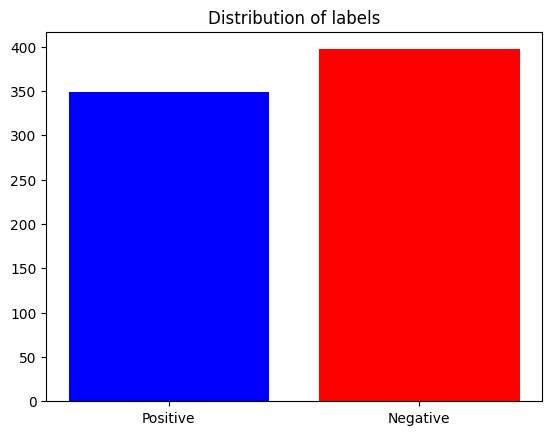

In [7]:

num_pos, num_neg = len(pos_files), len(neg_files)


plt.title('Distribution of labels')
plt.bar(['Positive', 'Negative'], [num_pos, num_neg], color=['blue', 'red'])  
plt.show()


Let's take a look at some of the images!

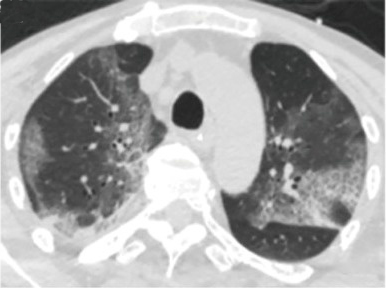

In [8]:
Image(images_train[1])
Image(images_train[15])
Image(images_train[66])

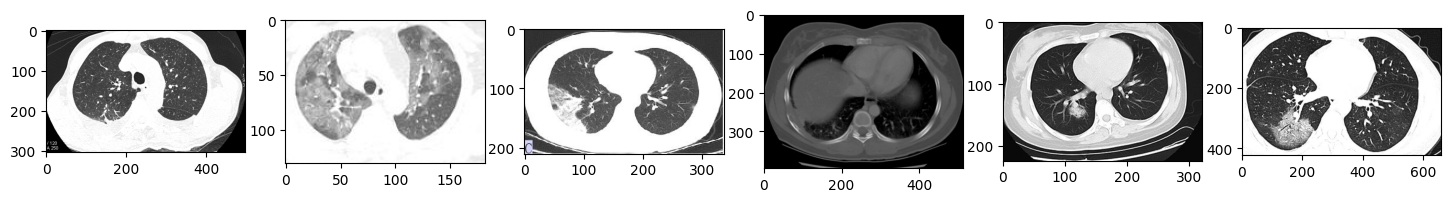

In [9]:
im = [cv2.imread(images_train[i]) for i in range(6)]

fig,ax = plt.subplots(ncols=6, figsize=(18,6))
for i in range(len(im)):
    ax[i].imshow(im[i],cmap='gray')

plt.show()

In [5]:
print(f'Number of samples in each set (train, val, test): {len(y_train), len(y_val), len(y_test)}')

print(f'Number of positive samples in each set: {y_train.sum(), y_val.sum(), y_test.sum()}')

Number of samples in each set (train, val, test): (447, 149, 150)
Number of positive samples in each set: (207, 71, 71)


Dataset Class

In [13]:
class CT_Dataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None, grayscale=True):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if (img_transforms is None) & (grayscale == True):
            self.transforms = transforms.Compose([transforms.Grayscale(),
                                                  transforms.Resize((250, 250)),
                                                  transforms.ToTensor()])
        elif grayscale == False:
            self.transforms = transforms.Compose([transforms.Resize((250, 250)),
                                                  transforms.ToTensor()])
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path).convert('RGB')
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

Model Development


In [7]:
# define CNN mode
class Convnet(nn.Module):
    
    def __init__(self, dropout=0.5):
        super(Convnet, self).__init__()
        self.convnet = nn.Sequential(
          # input (num_batch, 1, 250, 250)
          nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),  # (num_batch, 64, 248, 248)
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 64, 124, 124)

          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3), # (num_batch, 128, 122, 122)
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 128, 61, 61)

          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3), # (num_batch, 256, 59, 59)
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 256, 29, 29)

          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3), # (num_batch, 128, 27, 27)
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 128, 13, 13)
           nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3), # (num_batch, 64, 11, 11)
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),  # (num_batch, 64, 5, 5)
          nn.Flatten() # (num_batch, 1600)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),  # Dropout before first linear layer since it has a large number of trainable parameters
            nn.Linear(in_features= 12800, out_features=512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1)
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

Print model summary to visualize network structure

In [8]:
vision_model = Convnet()
summary(vision_model, (32, 1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Convnet                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 12800]               --
│    └─Conv2d: 2-1                       [32, 64, 248, 248]        640
│    └─BatchNorm2d: 2-2                  [32, 64, 248, 248]        128
│    └─ReLU: 2-3                         [32, 64, 248, 248]        --
│    └─MaxPool2d: 2-4                    [32, 64, 124, 124]        --
│    └─Conv2d: 2-5                       [32, 128, 122, 122]       73,856
│    └─BatchNorm2d: 2-6                  [32, 128, 122, 122]       256
│    └─ReLU: 2-7                         [32, 128, 122, 122]       --
│    └─MaxPool2d: 2-8                    [32, 128, 61, 61]         --
│    └─Conv2d: 2-9                       [32, 256, 59, 59]         295,168
│    └─BatchNorm2d: 2-10                 [32, 256, 59, 59]         512
│    └─ReLU: 2-11                        [32, 256, 59, 59]         --
│ 

Model Training Procedure

The training sequence used for our CNN model is summarized below:

  Loss Function: Binary Cross Entropy w/ Logistic Loss
  Optimizer: Adam Optimization
     To fight overfitting the following methods were used:
        L2 Regularization: Weight regularization using L2 Norm
        Learning Schedule: Decrease the learning rate over a set period of epochs
Parameters used for training:

Initial Learning Rate: 0.0002
Learning Schedule:
    Gamma: 0.5
    Patience: 7 epochs
Number of Epochs: 35
Batch Size: 32
L2 Weight Decay: 0.09

In [15]:
# define training function

def train_model(model, train_dataset, val_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=32, l2=0.00001, gamma=0.5,
                patience=7):
    model = model.to(device)

    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # set up loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)  # pass in the parameters to be updated and learning rate
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)
    # Training Loop
    print("Training Start:")
    for epoch in range(epochs):
        model.train()  # start to train the model, activate training behavior

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        for i, (images, labels) in enumerate(train_loader):
            # reshape images
            images = images.to(device)  # reshape: from (128, 1, 28, 28) -> (128, 28 * 28) = (128, 284), move batch to device
            labels = labels.to(device)  # move to device
            # forward
            outputs = model(images).view(-1)  # forward
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
    
            cur_train_loss = criterion(outputs, labels)  # loss
            cur_train_acc = (pred == labels).sum().item() / batch_size

            # backward
            cur_train_loss.backward()   # run back propagation
            optimizer.step()            # optimizer update all model parameters
            optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating
            # loss
            train_loss += cur_train_loss 
            train_acc += cur_train_acc
        
        # valid
        model.eval()  # start to train the model, activate training behavior
        with torch.no_grad():  # tell pytorch not to update parameters
            for images, labels in val_loader:
                # calculate validation loss
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images).view(-1)

                # loss
                cur_valid_loss = criterion(outputs, labels)
                val_loss += cur_valid_loss
                # acc
                pred = torch.sigmoid(outputs)
                pred = torch.round(pred)
                val_acc += (pred == labels).sum().item() / batch_size
# learning schedule step
        scheduler.step()

        # print training feedback
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)

        print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")
    
        # update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
    
    test_acc = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)

            # the class with the highest energy is what we choose as prediction
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
            test_acc += (pred == labels).sum().item()

    print(f'Test Accuracy:  {(test_acc / len(test_loader))}')

    return history

Process the datasets and train the model

In [10]:
# Load the data
train_dataset = CT_Dataset(img_path=images_train, img_labels=y_train)
val_dataset = CT_Dataset(img_path=images_val, img_labels=y_val)
test_dataset = CT_Dataset(img_path=images_test, img_labels=y_test)

# Train the CNN model
cnn_model = Convnet(dropout=0.5)
hist = train_model(cnn_model, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size=32, epochs=35, l2=0.09, patience=5)

Training Start:
Epoch:1 / 35, lr: 0.00020 train loss:0.66896, train acc: 0.56027, valid loss:0.70392, valid acc:0.48750
Epoch:2 / 35, lr: 0.00020 train loss:0.57993, train acc: 0.71205, valid loss:0.73487, valid acc:0.48750
Epoch:3 / 35, lr: 0.00020 train loss:0.55309, train acc: 0.71205, valid loss:0.70970, valid acc:0.48750
Epoch:4 / 35, lr: 0.00020 train loss:0.59220, train acc: 0.69420, valid loss:0.64854, valid acc:0.61875
Epoch:5 / 35, lr: 0.00010 train loss:0.53526, train acc: 0.70312, valid loss:0.69803, valid acc:0.50625
Epoch:6 / 35, lr: 0.00010 train loss:0.44312, train acc: 0.80580, valid loss:0.60250, valid acc:0.68125
Epoch:7 / 35, lr: 0.00010 train loss:0.43303, train acc: 0.78795, valid loss:0.78859, valid acc:0.51875
Epoch:8 / 35, lr: 0.00010 train loss:0.39050, train acc: 0.83259, valid loss:0.68445, valid acc:0.57500
Epoch:9 / 35, lr: 0.00010 train loss:0.31382, train acc: 0.88839, valid loss:0.58545, valid acc:0.62500
Epoch:10 / 35, lr: 0.00005 train loss:0.31144, t

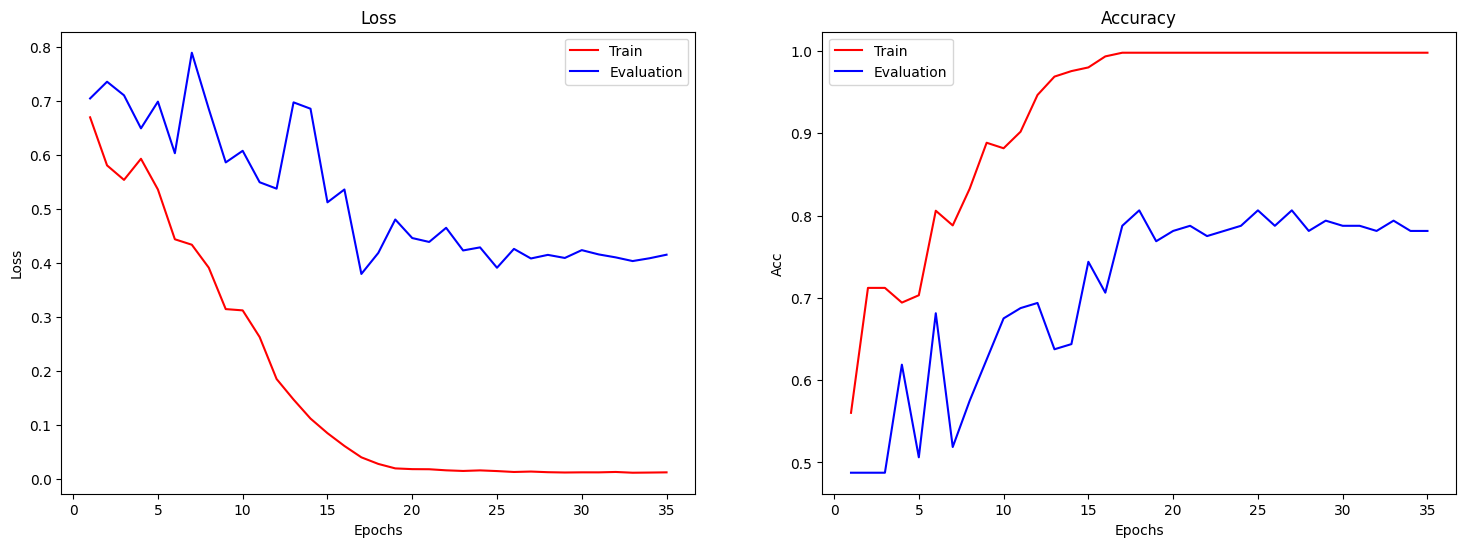

In [11]:

# Convert lists to PyTorch tensors
train_loss_tensor = torch.tensor(hist['train_loss'])
val_loss_tensor = torch.tensor(hist['val_loss'])
train_acc_tensor = torch.tensor(hist['train_acc'])
val_acc_tensor = torch.tensor(hist['val_acc'])

# Plot training curves
epochs = range(1, len(hist['train_loss']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(epochs, train_loss_tensor.detach().numpy(), 'r-', label='Train')
ax[0].plot(epochs, val_loss_tensor.detach().numpy(), 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, train_acc_tensor.detach().numpy(), 'r-', label='Train')
ax[1].plot(epochs, val_acc_tensor.detach().numpy(), 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()


Observations
•	The model begins to overfit on the training data after 10 epochs.
•	Training Accuracy generally reaches around 99% relatively quickly.
•	Validation accuracy stabilizes at around 78%.
•	Training loss converges to near zero.
•	Validation loss converges around 0.4.
•	Accuracy on the test set is 82% -- a surprising result given the validation performance.

Considerations to fight overfitting.
•	Add L1 Regularization.
•	Data Augmentation.
•	More hyperparameter tuning.


Augmentations Used
•	Grayscale
•	Resize → 250 x 250.
•	Random Affine
   Translate: Width → 0.01, Height → 0.001
   Image Scaling: Width → 1.2x, Height → 1.2x
   Shear: 0.9
•	Random Rotation: 20 degrees.
•	Convert Image to Tensor


Before Transformation


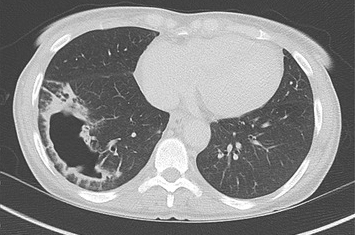


After Transformation


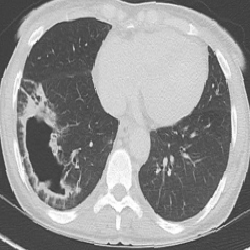

In [12]:
img = PIL.Image.open(images_train[10])

img_trans = transforms.Compose([transforms.Grayscale(),
                                transforms.RandomRotation(5),
                                transforms.Resize((250, 250)),
                                transforms.RandomAffine(degrees=0, scale=(1.1, 1.1), shear=0.9),
                                transforms.ToTensor()
                                ])
trans = img_trans(img)

print('Before Transformation')
display(img)
print('\nAfter Transformation')
display(transforms.ToPILImage()(trans))

Augmenting the entire Training Set

In [13]:
train_dataset_full_aug = CT_Dataset(img_path=images_train, img_labels=y_train, img_transforms=img_trans)
val_dataset = CT_Dataset(img_path=images_val, img_labels=y_val)
test_dataset = CT_Dataset(img_path=images_test, img_labels=y_test)

In [14]:
# Train the CNN model
cnn_model = Convnet()
hist_full_aug = train_model(cnn_model, train_dataset_full_aug, val_dataset, 
                            test_dataset, device, lr=0.0001, batch_size=32, epochs=35,
                            gamma=0.75, l2=0.09, patience=15)

Training Start:
Epoch:1 / 35, lr: 0.00010 train loss:0.68164, train acc: 0.56696, valid loss:0.69288, valid acc:0.48750
Epoch:2 / 35, lr: 0.00010 train loss:0.64645, train acc: 0.62054, valid loss:0.70024, valid acc:0.48750
Epoch:3 / 35, lr: 0.00010 train loss:0.61374, train acc: 0.67411, valid loss:0.71537, valid acc:0.48750
Epoch:4 / 35, lr: 0.00010 train loss:0.58118, train acc: 0.69866, valid loss:0.68459, valid acc:0.58750
Epoch:5 / 35, lr: 0.00010 train loss:0.54450, train acc: 0.71652, valid loss:0.59947, valid acc:0.65000
Epoch:6 / 35, lr: 0.00010 train loss:0.53440, train acc: 0.70312, valid loss:0.61184, valid acc:0.58750
Epoch:7 / 35, lr: 0.00010 train loss:0.50329, train acc: 0.75670, valid loss:0.60032, valid acc:0.64375
Epoch:8 / 35, lr: 0.00010 train loss:0.47126, train acc: 0.77009, valid loss:0.53639, valid acc:0.70000
Epoch:9 / 35, lr: 0.00010 train loss:0.45514, train acc: 0.78571, valid loss:0.93394, valid acc:0.55625
Epoch:10 / 35, lr: 0.00010 train loss:0.44445, t

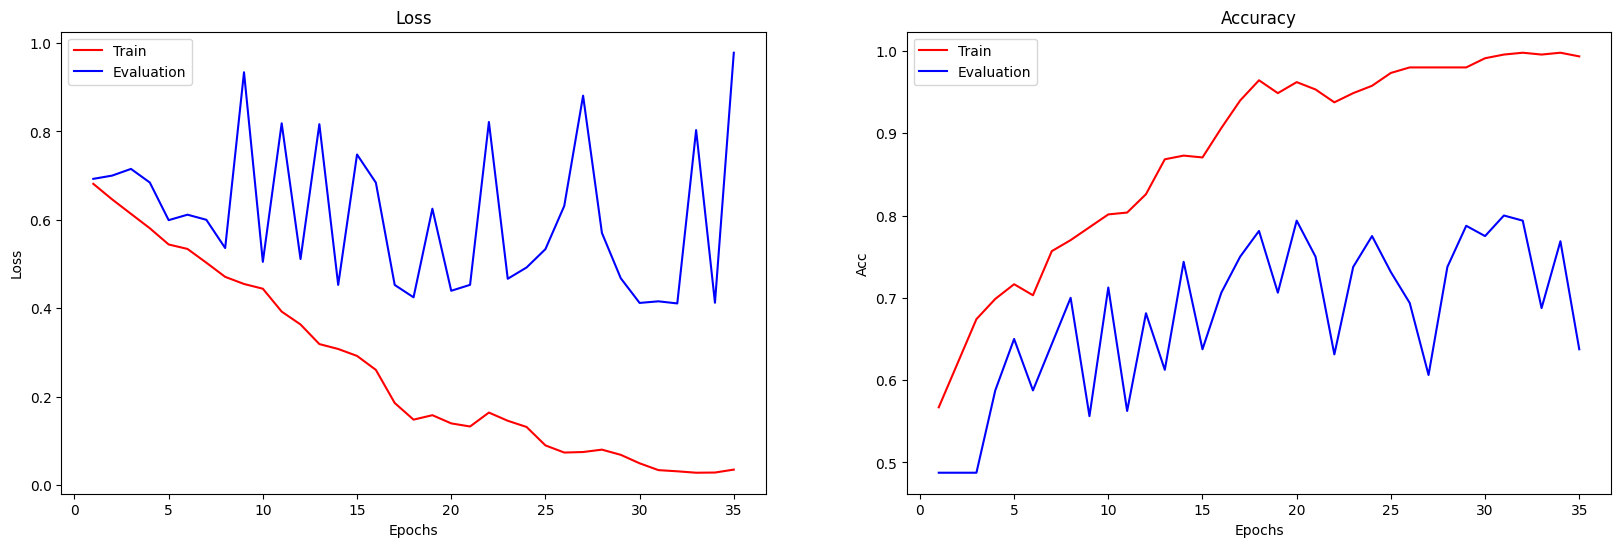

In [15]:

# plot training curves
epochs = range(1, len(hist_full_aug['train_loss']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Convert lists to PyTorch tensors
train_loss_tensor = torch.tensor(hist_full_aug['train_loss'])
val_loss_tensor = torch.tensor(hist_full_aug['val_loss'])
train_acc_tensor = torch.tensor(hist_full_aug['train_acc'])
val_acc_tensor = torch.tensor(hist_full_aug['val_acc'])

# Detach and convert to NumPy arrays
train_loss_np = train_loss_tensor.detach().numpy()
val_loss_np = val_loss_tensor.detach().numpy()
train_acc_np = train_acc_tensor.detach().numpy()
val_acc_np = val_acc_tensor.detach().numpy()

ax[0].plot(epochs, train_loss_np, 'r-', label='Train')
ax[0].plot(epochs, val_loss_np, 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, train_acc_np, 'r-', label='Train')
ax[1].plot(epochs, val_acc_np, 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()


Observations:
•	Drop in overall accuracy for both training and validation sets.
•	Test accuracy came out to be 76% -- a considerable drop compared to the initial model.
•	The drop in overall performance may suggest that perhaps lack of data could be a contributing factor rather than the diversity in available samples.


Closing Remarks.

After trying out different methods and models to detect COVID-19 in CT images, I'm excited to explore more data augmentation approaches on our current model. Adding more images to our training set gave us good results on the test set, so I want to dive deeper into this approach. I'm also keen to test out other pre-trained models like VGG-16 to see how they stack up against our current model.

Another idea I have is to create a user-friendly interface where people can upload their own images for analysis in real-time. This could be helpful for doctors and medical professionals.

Lastly, I believe it's crucial to keep collecting more data, especially with new variants of the virus emerging. We need to make sure our model stays up-to-date and effective by adjusting it to handle these changes.
